# AGN + Host Galaxy Fit - NGC 5728

This notebook demonstrates a fit to the Seyfert galaxy NGC 5728 and its host galaxy, using multiwavelegnth photometry collected in the Brown et al. (2019) '`AGNSEDATLAS`'. We collected X-ray photometry for the X-ray point source associated with the nucleus from the Chandra Source Catalog, in four bands: ultrasoft, soft, medium, and hard. Again we note that the X-ray and multiwavelength photometry are not simultaneous.

The mukltiwavelength photometry cover the entire extend of the galaxy, not just the nucleus, meaning that they contain significant contributions from the host galaxy. As we'll see, this dilution is significant enough that we can't conclusively detect the AGN component in our mid-IR photometry, only the X-rays. We use our SED fit to answer a common question, especially at high redshift in cases of obscured AGN: if we assume an Eddington fraction, what is the resulting BH mass? 

In [46]:
import numpy as np
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt

from lightning import Lightning
from lightning.priors import UniformPrior, ConstantPrior, NormalPrior
plt.style.use('lightning.plots.style.lightning-serif')

## Setup

Fitting the X-ray model to fluxes is somewhat less complicated than fitting it to an instrumental spectrum, since we will (usually) have fewer bands, and we have a more homegenous dataset.

For this example, our X-ray photometry array already contains the fluxes converted to $F_\nu$ in mJy, in addition to the fluxes in erg cm-2 s-1.

In [2]:
phot = Table.read('../photometry/NGC5728_photometry.fits', hdu=1)
# arf = Table.read('../photometry/Mrk231_arf3.fits', hdu=1)
xray_phot = Table.read('../photometry/NGC5728_xray_photometry.fits', hdu=1)

print(xray_phot['ENERG_LO', 'ENERG_HI', 'FLUX', 'FLUX_UNC', 'FNU', 'FNU_UNC'])

ENERG_LO ENERG_HI         FLUX               FLUX_UNC                 FNU                  FNU_UNC        
-------- -------- ------------------- ---------------------- ---------------------- ----------------------
     0.2      0.5 3.3193209249249e-15   1.19495553297295e-15 4.5758694416451106e-06 1.6473129989922206e-06
     0.5      1.2 3.0089184021393e-14 2.7653864684520005e-15 1.7776980912010367e-05 1.6338170695838985e-06
     1.2      2.0 1.2659455462062e-14 1.9651777694714992e-15  6.544412626887014e-06   1.01591527748952e-06
     2.0      7.0 7.6863430873421e-13 5.0862225098379986e-14  6.357632162758945e-05  4.206985226660801e-06


In [79]:
filter_labels = phot['FILTER_LABELS']
fnu_obs = phot['FNU']
fnu_unc = phot['FNU_UNC']
lumdist = 29 # From NED
galactic_NH = 7.8 # e20 cm-2; from Colden.

In [4]:
xray_filter_labels = xray_phot['FILTER_LABELS']
xray_fnu = xray_phot['FNU']
xray_fnu_unc = xray_phot['FNU_UNC']

The X-ray fluxes and filter labels are concatenated to their UV-IR counterparts.

In [6]:
obs_full = np.zeros(len(xray_filter_labels) + len(filter_labels))
unc_full = np.zeros(len(xray_filter_labels) + len(filter_labels))
exp_full = np.zeros(len(xray_filter_labels) + len(filter_labels))

filter_labels_full = np.array(list(xray_filter_labels) + list(filter_labels))
xray_mask = np.array(['XRAY' in s for s in filter_labels_full])
obs_full[xray_mask] = xray_fnu
obs_full[~xray_mask] = fnu_obs 
unc_full[xray_mask] = xray_fnu_unc
unc_full[~xray_mask] = fnu_unc 
exp_full[xray_mask] = 1

In [7]:
t = Table()
t['filter'] = filter_labels_full
t['flux'] = obs_full
t['unc'] = unc_full

ascii.write(t, format='fixed_width_two_line')

          filter                   flux                    unc
---------------- ---------------------- ----------------------
XRAY_0.2_0.5_keV 4.5758694416451106e-06 1.6473129989922206e-06
XRAY_0.5_1.2_keV 1.7776980912010367e-05 1.6338170695838985e-06
XRAY_1.2_2.0_keV  6.544412626887014e-06   1.01591527748952e-06
XRAY_2.0_7.0_keV  6.357632162758945e-05  4.206985226660801e-06
       GALEX_FUV                   0.52   0.026000000000000002
       GALEX_NUV                   1.16   0.057999999999999996
       UVOT_UVW2                   0.82                  0.041
       UVOT_UVM2                   0.88   0.044000000000000004
       UVOT_UVW1                   1.35                 0.0675
          UVOT_U                   3.64    0.18200000000000002
          UVOT_B                   9.43    0.47150000000000003
          UVOT_V                   18.4     0.9199999999999999
  Pan-STARRS_gp1                   17.2                   0.86
  Pan-STARRS_rp1                   31.5     1.575000000

The galaxy is 4-5 orders of magnitude fainter in the X-rays than in the UV-optical (in terms of $F_\nu$).

We construct our X-ray wavelength grid to cover the ultrasoft 0.2-0.5 keV band all the way to the hard 2-7 keV band (even though it's probably not helpful to include the ultrasoft band, as we'll see).

In [80]:
hc_um = (const.c * const.h).to(u.micron * u.keV).value
lam_02 = hc_um / 0.2
lam_70 = hc_um / 7.0
xray_wave_grid = np.logspace(np.log10(lam_70), np.log10(lam_02), 200)

Our model specification uses the default 5 age bin SFH, the simple Calzetti model (although we have sufficient data quality in the UV and IR to use a more complex model), the QSOSED model, and the power law stellar population X-ray model. Since we're using point source photometry for the nucleus, the X-ray stellar population model will likely overpredict the contribution of the stellar population to the X-rays. We'll trying fitting without it later.

In [28]:
lgh = Lightning(filter_labels_full,
                lum_dist=lumdist,
                flux_obs=obs_full,
                flux_obs_unc=unc_full,
                SFH_type='Piecewise-Constant',
                atten_type='Calzetti',
                dust_emission=True,
                agn_emission=True,
                agn_polar_dust=True,
                xray_mode='flux',
                xray_stellar_emission='Stellar-Plaw',
                xray_agn_emission='QSOSED',
                xray_absorption='tbabs',
                xray_wave_grid=xray_wave_grid,
                xray_arf={'ENERG_LO':[0,1],'ENERG_HI':[1,2], 'SPECRESP':[1,1]},
                xray_exposure=exp_full,
                galactic_NH=galactic_NH,
                model_unc=0.10,
                print_setup_time=True)

0.027 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
0.550 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.155 s elapsed in dust emission model setup
0.028 s elapsed in agn emission model setup
0.047 s elapsed in X-ray model setup
0.806 s elapsed total


/Users/eqm5663/Research/code/plightning/lightning/get_filters.py:138: RuntimeWarning: invalid value encountered in divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


In [57]:
lgh.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Pegase-Stellar
Parameter    Lo  Hi                                      Description
--------- ----- --- ------------------------------------------------
     Zmet 0.001 0.1 Metallicity (mass fraction, where solar = 0.020)

Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation 

Rather than assuming a single, constant value of the Eddington ratio, we'll assume a normal prior centered on -1.0, with a 0.3 dex standard deviation. This uncertainty will thus be propagated to our estimate of the BH mass.

In [74]:
priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          ConstantPrior([0.020]), # Metallicity
          UniformPrior([0, 3]), # tauV
          ConstantPrior([2]), # alpha
          # ConstantPrior([1]), # Umin
          UniformPrior([0.1, 25]), # Umin
          ConstantPrior([3e5]), # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          UniformPrior([10,13]), # log L_AGN
          UniformPrior([0.0, 0.5]), # cos i - Limited to Type-2 views.
          UniformPrior([3,11]), # tau 9.7
          UniformPrior([0,1]), # polar dust tauV
          ConstantPrior([1.8]), # stellar pop. pho. index
          # UniformPrior([1.0, 2.5]), # AGN pho. index
          # UniformPrior([-1.3, 1.3]), # log deviation from Lusso + Risaliti 2017
          UniformPrior([5.0, 9.0]), # log BH mass
          # UniformPrior([-1.5, 0.0]), # log Eddington
          NormalPrior([-1.0, 0.3]), # log Eddington
          UniformPrior([1, 1e3]) # NH
          ]

Nwalkers = 64

p0s = [pr.sample(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=-1)

p0[p0[:,-2] < -1.5, -2] = -1.5
p0[p0[:,-2] > 0.3, -2] = 0.3

Nsteps = 40000
const_dim = np.array([False, False, False, False, False,
                      True,
                      False,
                      True, False, True, False, False,
                      True, False, False, False,
                      True,
                      False, False,
                      False
                      ])

# print(p0[0,:])

In [75]:
mcmc = lgh.fit(p0,
               method='emcee',
               Nwalkers=Nwalkers,
               Nsteps=Nsteps,
               priors=priors,
               const_dim=const_dim)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [23:35<00:00, 28.26it/s]


In [76]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain, logprob_chain, t = lgh.get_mcmc_chains(mcmc,
                                              discard=3000,
                                              thin=500,
                                              Nsamples=500,
                                              const_dim=const_dim,
                                              const_vals=p0[0,const_dim])

MCMC mean acceptance fraction: 0.214


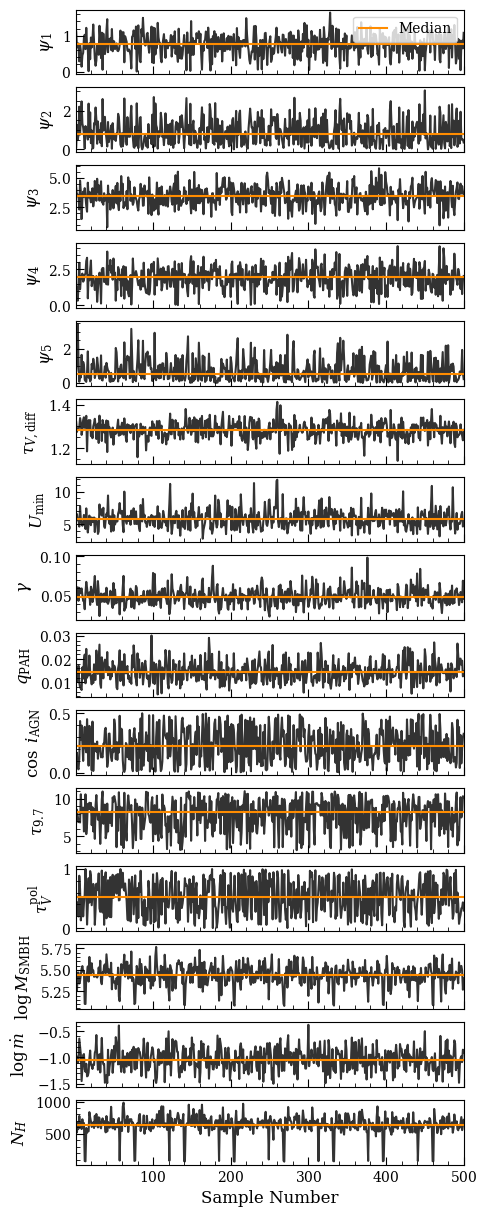

In [77]:
fig, axs = lgh.chain_plot(chain, color='black', alpha=0.8)

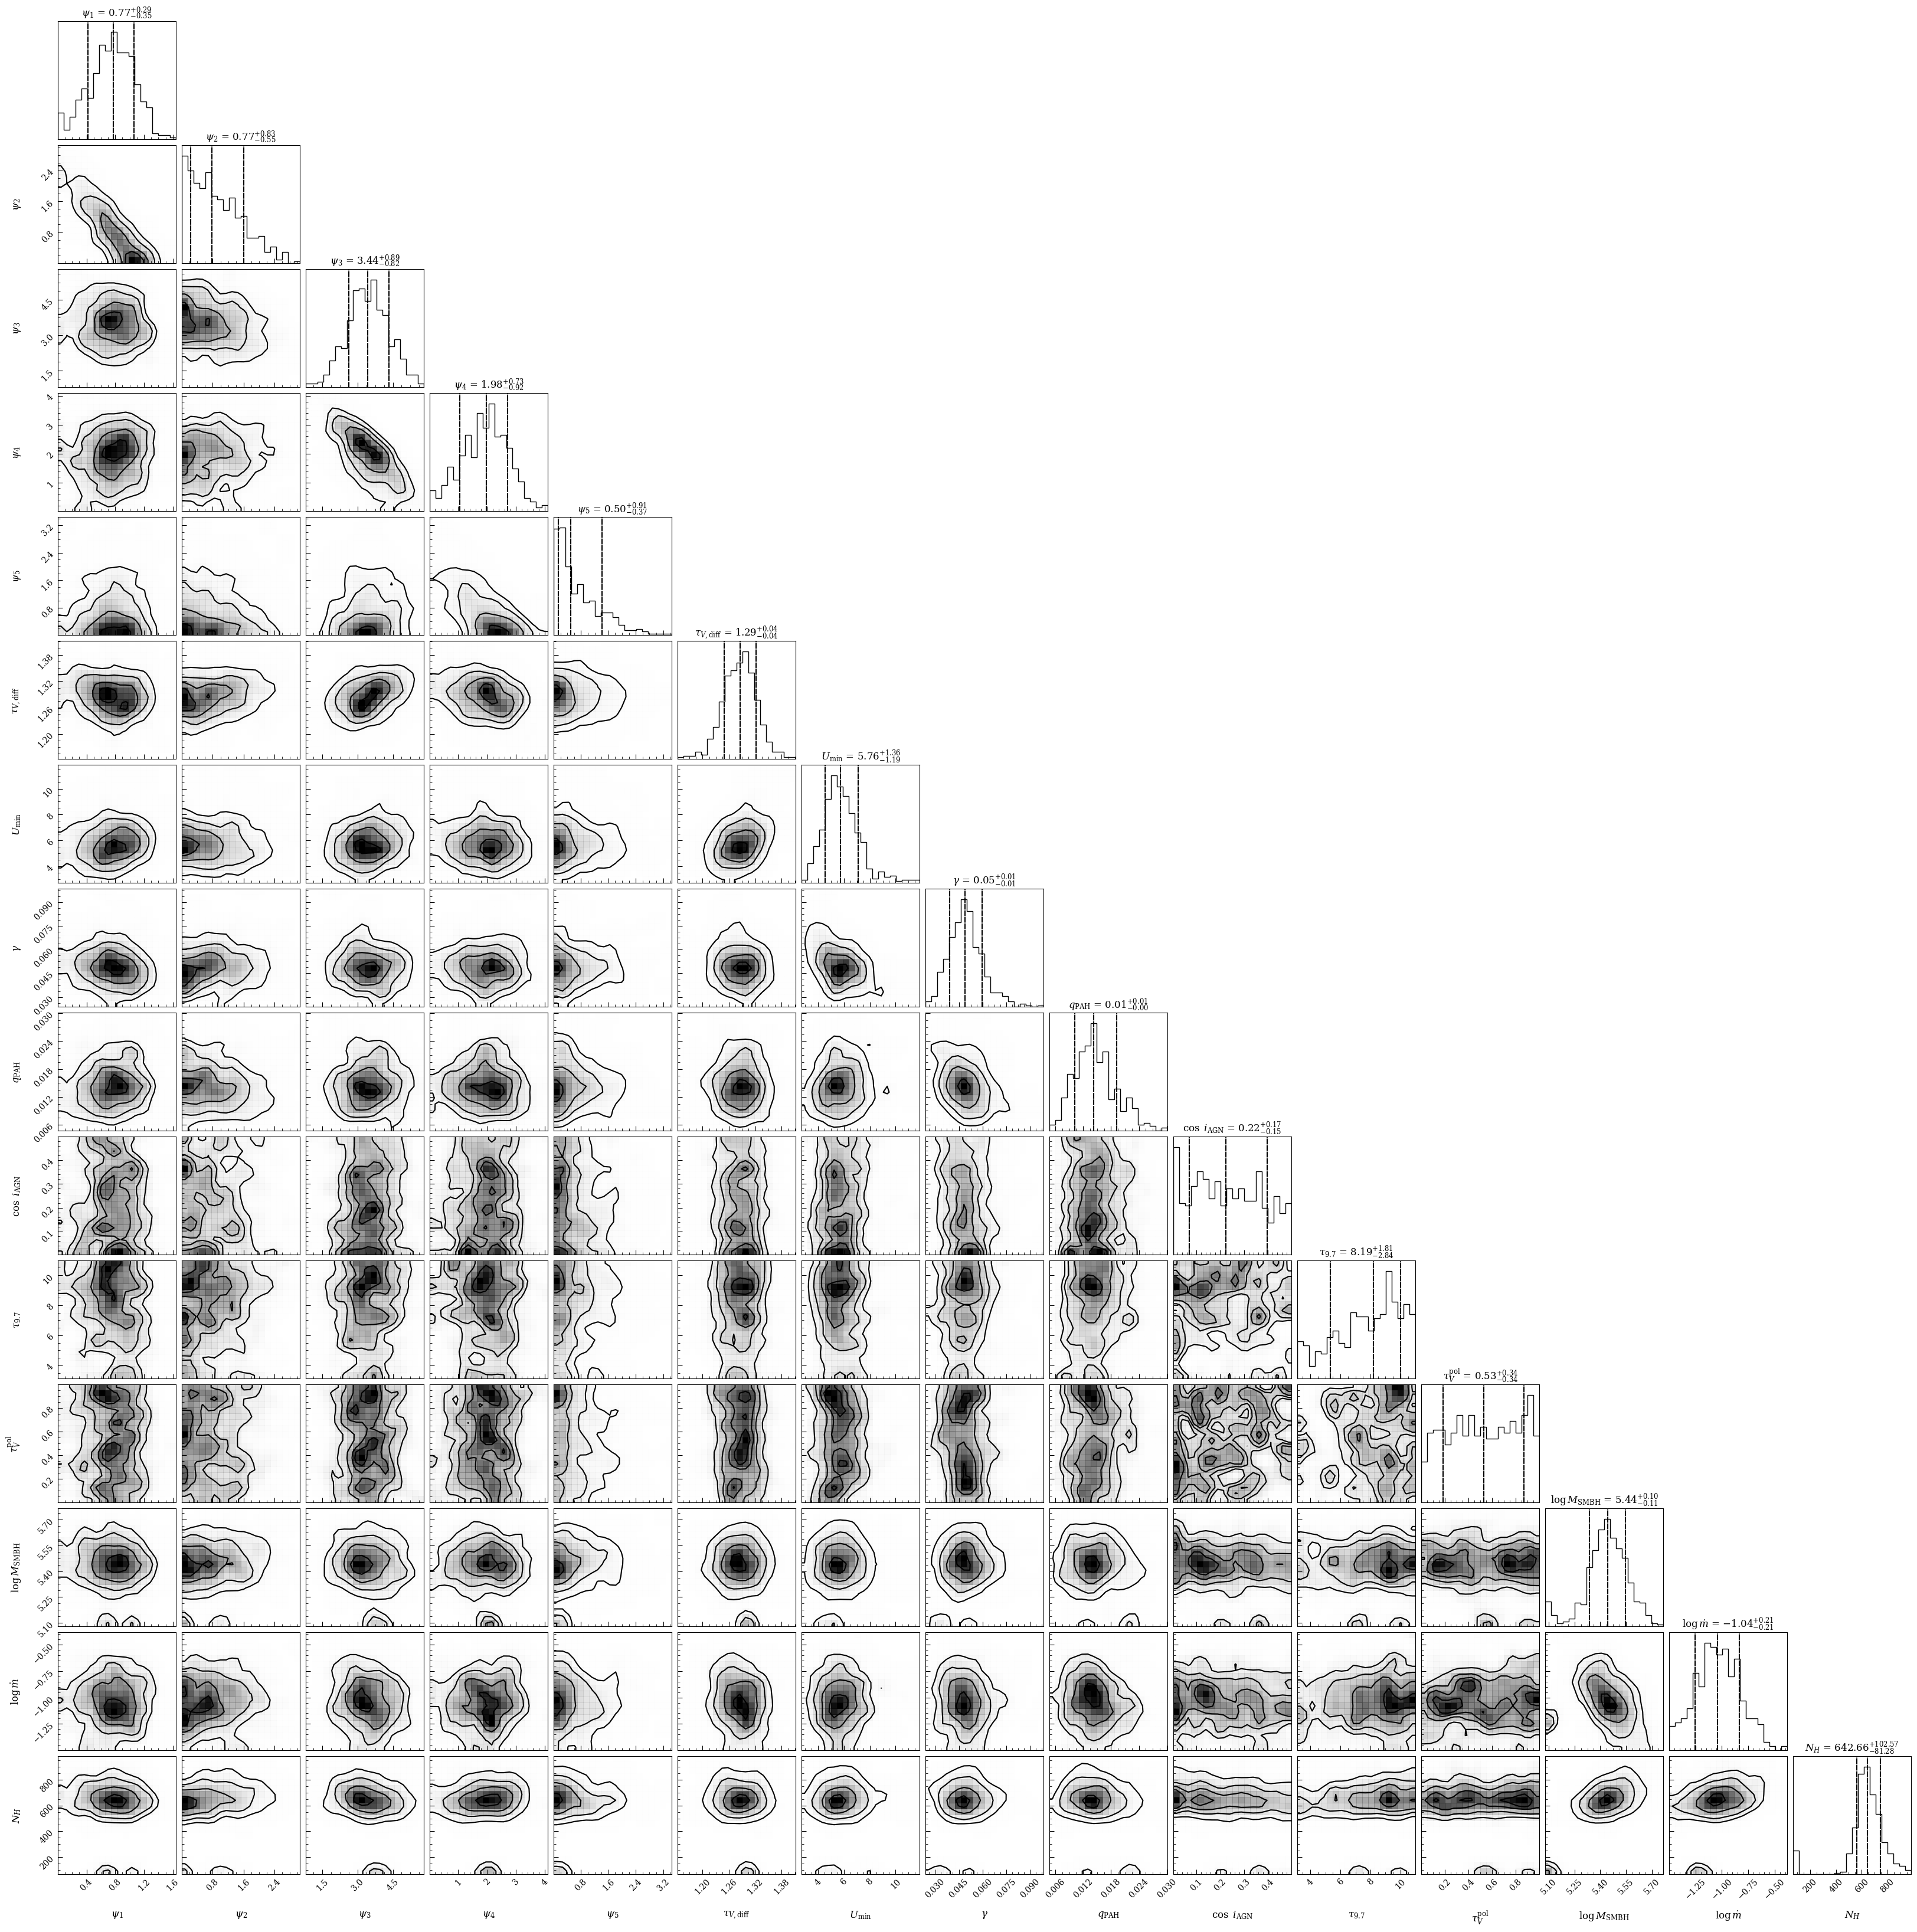

In [78]:
fig = lgh.corner_plot(chain, 
                      quantiles=(0.16, 0.50, 0.84),
                      smooth=1,
                      levels=None,
                      show_titles=True)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


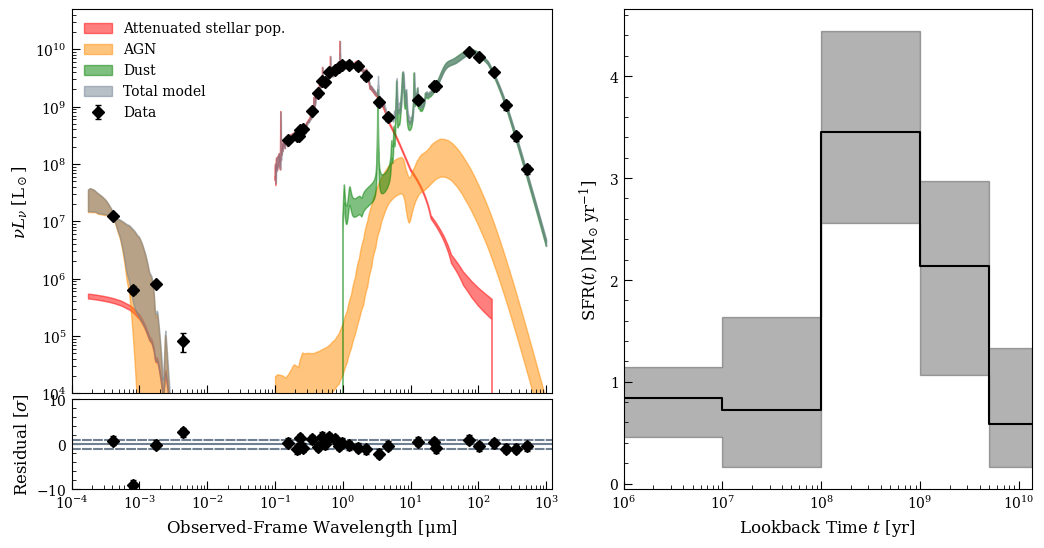

In [71]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'upper left', 'frameon': False})
ax51.set_xticklabels([])
ax51.set_xlim(1e-4, 1200)
ax51.set_ylim(1e4,5e10)
fig5, ax52 = lgh.sed_plot_delchi(chain, logprob_chain, ax=ax52)
ax52.set_xlim(1e-4, 1200)
ax52.set_ylim(-10, 10)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

We can see that our model is predicting that a significant chunk of the X-rays come from the stellar population. We also do a very bad job at reproducing the Medium 1.2-2.0 keV flux; this may be due to underestimation of the uncertainties on this relatively narrow band. 

Below, we show the posteriors on the stellar mass and BH mass.

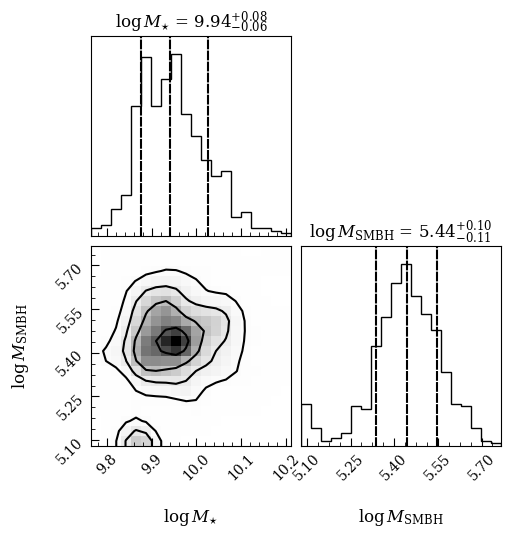

In [86]:
# We need these to determine the posterior on the total stellar mass;
# they are the ratio of the surving stellar mass to star formation
# rate as a function of age. They also depend on metallicity, so the
# stellar population models include a convenience function for extracting
# the appropriate coefficients for each metallicity.
mstar_coeff = lgh.stars.get_mstar_coeff(chain[:,5])
mstar_chain = np.sum(mstar_coeff * chain[:,:5], axis=1)

samples = np.stack([np.log10(mstar_chain), chain[:,-3]], axis=-1)
labels = [r'$\log M_{\star}$', r'$\log M_{\rm SMBH}$']

import corner
fig = corner.corner(samples, labels=labels, show_titles=True, quantiles=(0.16, 0.50, 0.84), smooth=1)


Our resulting BH mass is a few hundred thousand solar masses, relatively low considering the total stellar mass of the galaxy. We could however, assume an even lower Eddington ratio and find a larger mass.

Note that the stellar mass we're looking at is the entire galaxy, not only the bulge, since we don't have independent photometry for the bulge; we would need to assume a B/T ratio to convert $M_{\star}$ into a bulge mass. 

Below we re-fit the data, now assuming no contributions to the X-ray flux from the stellar population of the galaxy.

In [88]:
lgh = Lightning(filter_labels_full,
                lum_dist=lumdist,
                flux_obs=obs_full,
                flux_obs_unc=unc_full,
                SFH_type='Piecewise-Constant',
                atten_type='Calzetti',
                dust_emission=True,
                agn_emission=True,
                agn_polar_dust=True,
                xray_mode='flux',
                xray_stellar_emission='None',
                xray_agn_emission='QSOSED',
                xray_absorption='tbabs',
                xray_wave_grid=xray_wave_grid,
                xray_arf={'ENERG_LO':[0,1],'ENERG_HI':[1,2], 'SPECRESP':[1,1]},
                xray_exposure=exp_full,
                galactic_NH=galactic_NH,
                model_unc=0.10,
                print_setup_time=True)

0.020 s elapsed in _get_filters
0.001 s elapsed in _get_wave_obs
0.547 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.097 s elapsed in dust emission model setup
0.022 s elapsed in agn emission model setup
0.031 s elapsed in X-ray model setup
0.717 s elapsed total


/Users/eqm5663/Research/code/plightning/lightning/get_filters.py:138: RuntimeWarning: invalid value encountered in divide
  transm_norm_interp = transm_interp / trapz(transm_interp, wave_grid)


In [89]:
lgh.print_params(verbose=True)


Piecewise-Constant
Parameter  Lo  Hi              Description
--------- --- --- ------------------------
    psi_1 0.0 inf SFR in stellar age bin 1
    psi_2 0.0 inf SFR in stellar age bin 2
    psi_3 0.0 inf SFR in stellar age bin 3
    psi_4 0.0 inf SFR in stellar age bin 4
    psi_5 0.0 inf SFR in stellar age bin 5

Pegase-Stellar
Parameter    Lo  Hi                                      Description
--------- ----- --- ------------------------------------------------
     Zmet 0.001 0.1 Metallicity (mass fraction, where solar = 0.020)

Calzetti
     Parameter  Lo  Hi                      Description
-------------- --- --- --------------------------------
calz_tauV_diff 0.0 inf Optical depth of the diffuse ISM

DL07-Dust
      Parameter     Lo       Hi                                                             Description
--------------- ------ -------- -----------------------------------------------------------------------
dl07_dust_alpha  -10.0      4.0                  Radiation 

In [90]:
priors = [UniformPrior([0, 1e1]), # SFH
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          UniformPrior([0, 1e1]),
          ConstantPrior([0.020]), # Metallicity
          UniformPrior([0, 3]), # tauV
          ConstantPrior([2]), # alpha
          # ConstantPrior([1]), # Umin
          UniformPrior([0.1, 25]), # Umin
          ConstantPrior([3e5]), # Umax
          UniformPrior([0,1]), # Gamma
          UniformPrior([0.0047, 0.0458]), #qPAH
          UniformPrior([10,13]), # log L_AGN
          UniformPrior([0.0, 0.5]), # cos i - Limited to Type-2 views.
          UniformPrior([3,11]), # tau 9.7
          UniformPrior([0,1]), # polar dust tauV
          # UniformPrior([1.0, 2.5]), # AGN pho. index
          # UniformPrior([-1.3, 1.3]), # log deviation from Lusso + Risaliti 2017
          UniformPrior([5.0, 9.0]), # log BH mass
          # UniformPrior([-1.5, 0.0]), # log Eddington
          NormalPrior([-1.0, 0.3]), # log Eddington
          UniformPrior([1, 1e3]) # NH
          ]

Nwalkers = 64

p0s = [pr.sample(Nwalkers) for pr in priors]
p0 = np.stack(p0s, axis=-1)

p0[p0[:,-2] < -1.5, -2] = -1.5
p0[p0[:,-2] > 0.3, -2] = 0.3

Nsteps = 40000
const_dim = np.array([False, False, False, False, False,
                      True,
                      False,
                      True, False, True, False, False,
                      True, False, False, False,
                      False, False,
                      False
                      ])

# print(p0[0,:])

In [91]:
mcmc = lgh.fit(p0,
               method='emcee',
               Nwalkers=Nwalkers,
               Nsteps=Nsteps,
               priors=priors,
               const_dim=const_dim)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [19:29<00:00, 34.19it/s]


In [92]:
print('MCMC mean acceptance fraction: %.3f' % (np.mean(mcmc.acceptance_fraction)))
chain, logprob_chain, t = lgh.get_mcmc_chains(mcmc,
                                              discard=3000,
                                              thin=500,
                                              Nsamples=500,
                                              const_dim=const_dim,
                                              const_vals=p0[0,const_dim])

MCMC mean acceptance fraction: 0.219


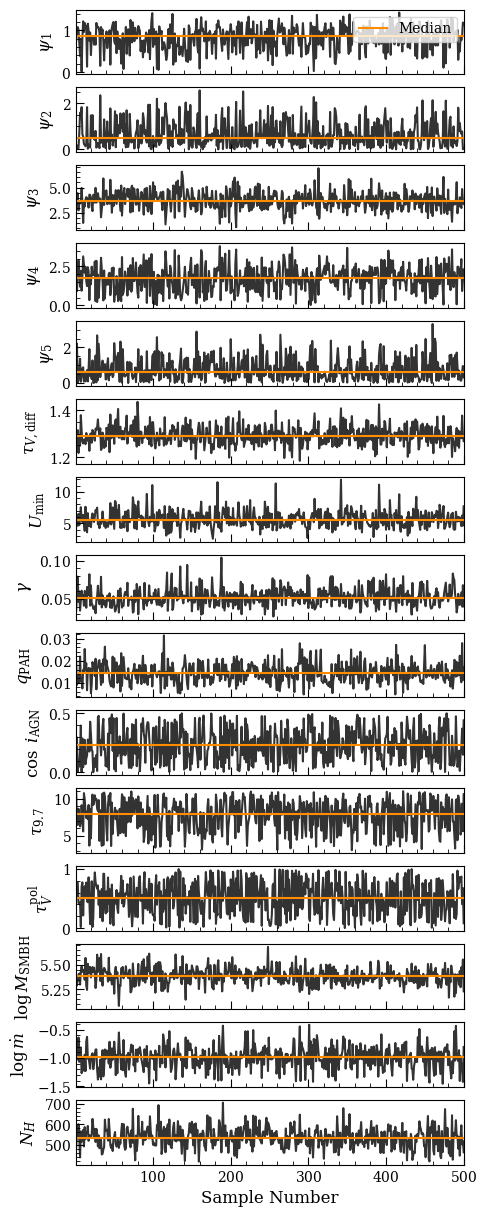

In [93]:
fig, axs = lgh.chain_plot(chain, color='black', alpha=0.8)

/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/eqm5663/Research/code/plightning/lightning/stellar/pegase.py:449: RuntimeWarning: divide by zero encountered in log10
  finterp = interp1d(self.Zmet, np.log10(self.Lnu_obs), axis=1)
/Users/eqm5663/miniconda3_arm64/envs/ciao-4.16/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


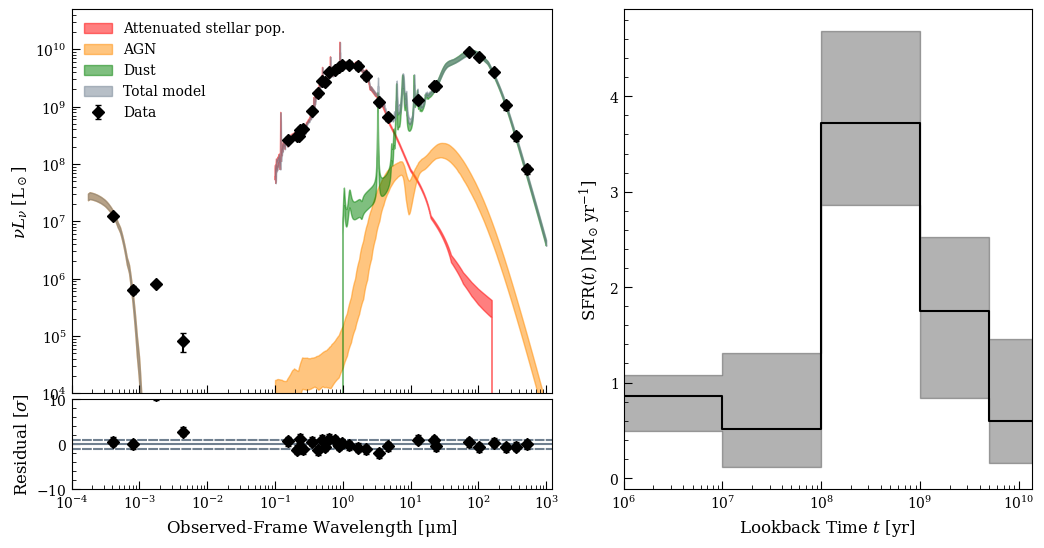

In [94]:
from lightning.plots import sed_plot_morebayesian, sed_plot_delchi_morebayesian, sfh_plot

fig5 = plt.figure(figsize=(12,6))
ax51 = fig5.add_axes([0.1, 0.26, 0.4, 0.64])
ax52 = fig5.add_axes([0.1, 0.1, 0.4, 0.15])
ax53 = fig5.add_axes([0.56, 0.1, 0.34, 0.8])

fig5, ax51 = sed_plot_morebayesian(lgh, chain, logprob_chain,
                                   plot_components=True,
                                   ax=ax51,
                                   legend_kwargs={'loc': 'upper left', 'frameon': False})
ax51.set_xticklabels([])
ax51.set_xlim(1e-4, 1200)
ax51.set_ylim(1e4,5e10)
fig5, ax52 = lgh.sed_plot_delchi(chain, logprob_chain, ax=ax52)
ax52.set_xlim(1e-4, 1200)
ax52.set_ylim(-10, 10)
fig5, ax53 = lgh.sfh_plot(chain, ax=ax53)

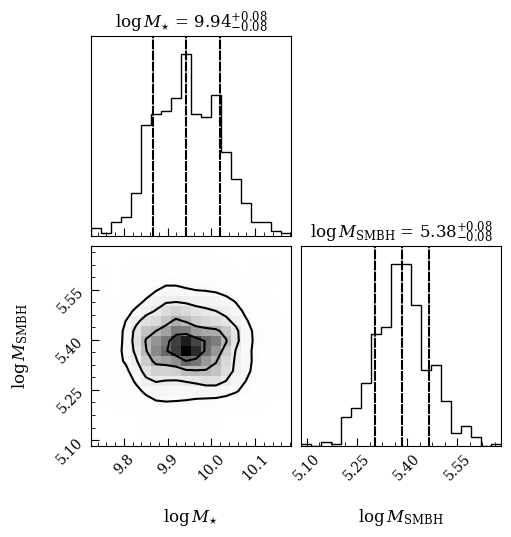

In [95]:
mstar_coeff = lgh.stars.get_mstar_coeff(chain[:,5])
mstar_chain = np.sum(mstar_coeff * chain[:,:5], axis=1)

samples = np.stack([np.log10(mstar_chain), chain[:,-3]], axis=-1)
labels = [r'$\log M_{\star}$', r'$\log M_{\rm SMBH}$']

import corner
fig = corner.corner(samples, labels=labels, show_titles=True, quantiles=(0.16, 0.50, 0.84), smooth=1)


We find much the same result as when we included the stellar population model in the X-rays, only now we successfully fit the M and H bands rather than the S and H bands. As a next step, we might try to match the SNR of the X-ray data to the UV-IR data to get a better fit in the X-rays.